# SP LIME

## Regression explainer with boston housing prices dataset

In [28]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import sklearn.linear_model
import sklearn.model_selection
import numpy as np
from sklearn.metrics import r2_score
np.random.seed(1)

#load example dataset
boston = load_boston()

#print a description of the variables
print(boston.DESCR)

#train a regressor
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(boston.data, boston.target, train_size=0.80, test_size=0.20)
rf.fit(train, labels_train);

#train a linear regressor
lr = sklearn.linear_model.LinearRegression()
lr.fit(train,labels_train)

#print the R^2 score of the random forest
print("Random Forest R^2 Score: " +str(round(r2_score(rf.predict(test),labels_test),3)))
print("Linear Regression R^2 Score: " +str(round(r2_score(lr.predict(test),labels_test),3)))

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [29]:
# import lime tools
import lime
import lime.lime_tabular

# generate an "explainer" object
categorical_features  = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names, class_names=['price'], categorical_features=categorical_features, verbose=False, mode='regression',discretize_continuous=False)

In [30]:
#generate an explanation
i = 13
exp = explainer.explain_instance(test[i], rf.predict, num_features=14)

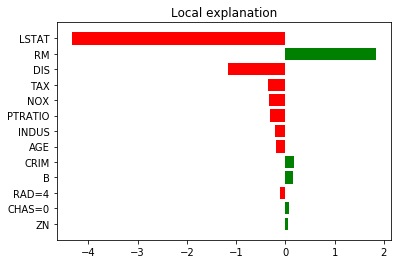

In [31]:
%matplotlib inline
fig = exp.as_pyplot_figure();

In [32]:
print("Input feature names: ")
print(boston.feature_names)
print('\n')

print("Input feature values: ")
print(test[i])
print('\n')

print("Predicted: ")
print(rf.predict(test)[i])

Input feature names: 
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


Input feature values: 
[4.3790e-02 8.0000e+01 3.3700e+00 0.0000e+00 3.9800e-01 5.7870e+00
 3.1100e+01 6.6115e+00 4.0000e+00 3.3700e+02 1.6100e+01 3.9690e+02
 1.0240e+01]


Predicted: 
20.16219999999996


In [33]:
class SubmodularPick(object):
        """Class for submodular pick"""
        
        def __init__(self, 
                     explainer,
                     data,
                     predict_fn,
                     method='sample',
                     sample_size=1000,
                     num_exps_desired=5,
                     num_features=10,
                     **kwargs):
            
            """Saves a representative sample of explanation objects using SP-LIME,
            as well as saving all generated explanations 

            First, a collection of candidate explanations are generated
            (see explain_instance). From these candidates, num_exps_desired are
            chosen using submodular pick. (see marcotcr et al paper).


            Args:
                data: a numpy array where each row is a single input into predict_fn
                predict_fn: prediction function. For classifiers, this should be a
                        function that takes a numpy array and outputs prediction
                        probabilities. For regressors, this takes a numpy array and
                        returns the predictions. For ScikitClassifiers, this is
                        `classifier.predict_proba()`. For ScikitRegressors, this
                        is `regressor.predict()`. The prediction function needs to work
                        on multiple feature vectors (the vectors randomly perturbed
                        from the data_row).
                method: The method to use to generate candidate explanations
                        method == 'sample' will sample the data uniformly at
                        random. The sample size is given by sample_size. Otherwise
                        if method == 'full' then explanations will be generated for the
                        entire data.
                sample_size: The number of instances to explain if method == 'sample'
                num_exps_desired: The number of explanation objects returned.
                num_features: maximum number of features present in explanation


            Sets value:
                sp_explanations: A list of explanation objects that has a high coverage
                explanations: All the candidate explanations saved for potential future use.
                  """
        
            # Parse args
            if method == 'sample':
                if sample_size > len(data):
                    warnings.warn("""Requested sample size larger than
                                  size of input data. Using all data""")
                    sample_size = len(data)
                all_indices = np.arange(len(data))
                np.random.shuffle(all_indices)
                sample_indices = all_indices[:sample_size]
            elif method == 'full':
                sample_indices = np.arange(len(data))

            # Generate Explanations
            self.explanations = []
            for i in sample_indices:
               self.explanations.append(
                    explainer.explain_instance(
                        data[i], predict_fn, num_features=num_features,
                    **kwargs))
            # Error handling
            try:
                num_exps_desired = int(num_exps_desired)
            except TypeError:
                return("Requested number of explanations should be an integer")
            if num_exps_desired > len(self.explanations):
                warnings.warn("""Requested number of explanations larger than
                               total number of explanations, returning all
                               explanations instead.""")
            num_exps_desired = min(num_exps_desired, len(self.explanations))

            # Find all the explanation model features used. Defines the dimension d'
            features_dict = {}
            feature_iter = 0
            for exp in self.explanations:
                try:
                    for this_label in exp.available_labels():
                        for feature, _ in exp.as_list(label=this_label):
                            if feature not in features_dict.keys():
                                features_dict[feature] = (feature_iter)
                                feature_iter += 1
                except NotImplementedError:
                    for feature, _ in exp.as_list():
                        if feature not in features_dict.keys():
                            features_dict[feature] = (feature_iter)
                            feature_iter += 1
            d_prime = len(features_dict.keys())

            # Create the n x d' dimensional 'explanation matrix', W
            W = np.zeros((len(self.explanations), d_prime))
            for i, exp in enumerate(self.explanations):
                for feature, value in exp.as_list():
                    W[i, features_dict[feature]] = value

            # Create the global importance vector, I_j described in the paper
            importance = np.sum(abs(W), axis=0)**.5

            # Now run the SP-LIME greedy algorithm
            remaining_indices = set(range(len(self.explanations)))
            V = []
            for _ in range(num_exps_desired):
                best = 0
                best_ind = None
                current = 0
                for i in remaining_indices:
                    current = np.dot(
                            (np.sum(abs(W)[V + [i]], axis=0) > 0), importance
                            )  # coverage function
                    if current >= best:
                        best = current
                        best_ind = i
                V.append(best_ind)
                remaining_indices -= {best_ind}

            self.sp_explanations = [self.explanations[i] for i in V]

# SP-LIME pick step

### Maximize the 'coverage' function:

$c(V,W,I) = \sum_{j=1}^{d^{\prime}}{\mathbb{1}_{[\exists i \in V : W_{ij}>0]}I_j}$

$W = \text{Explanation Matrix,  } n\times d^{\prime}$

$V = \text{Set of chosen explanations}$

$I = \text{Global feature importance vector,   } I_j = \sqrt{\sum_i{|W_{ij}|}}$

In [34]:
import warnings
sp_obj = SubmodularPick(explainer, train, rf.predict, sample_size=20, num_features=14,num_exps_desired=5)

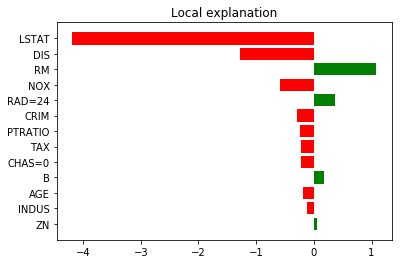

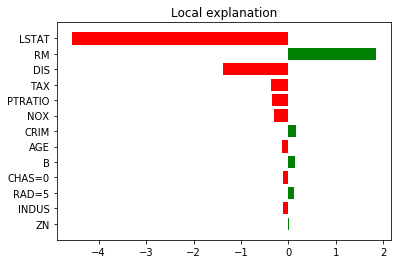

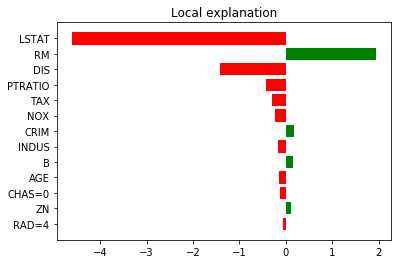

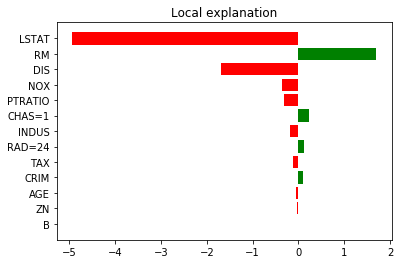

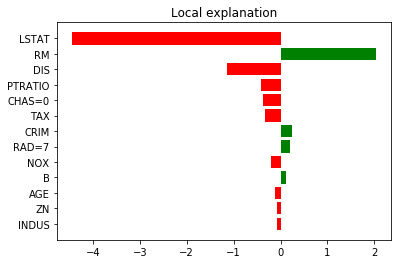

In [35]:
[exp.as_pyplot_figure() for exp in sp_obj.sp_explanations];

In [36]:
import pandas as pd
W=pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])

In [37]:
W.head()

,AGE,B,CHAS=0,CHAS=1,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD=2,RAD=24,RAD=3,RAD=4,RAD=5,RAD=7,RM,TAX,ZN
0,-0.057490,-0.001675,NaN,0.221949,0.097950,-1.689589,-0.195349,-4.943962,-0.357396,-0.316519,NaN,0.128580,NaN,NaN,NaN,NaN,1.698543,-0.117684,-0.031437
1,-0.127459,0.057808,-0.066255,NaN,0.111473,-1.531901,-0.236689,-4.741594,-0.212246,-0.516197,-0.102151,NaN,NaN,NaN,NaN,NaN,2.025870,-0.326354,0.097508
2,-0.180283,0.046985,0.034000,NaN,0.022352,-1.461229,-0.126670,-4.991636,-0.498466,-0.323377,NaN,0.122342,NaN,NaN,NaN,NaN,1.389297,-0.145721,0.056585
3,-0.175469,0.039349,0.032463,NaN,0.241725,-1.141662,-0.124166,-4.403933,-0.176848,-0.411888,NaN,NaN,NaN,-0.064857,NaN,NaN,2.041430,-0.292045,-0.028940
4,-0.115612,0.098805,-0.301262,NaN,0.287439,-1.606070,-0.160903,-4.790266,-0.262304,-0.397852,NaN,NaN,NaN,-0.204295,NaN,NaN,1.940261,-0.356099,0.016996


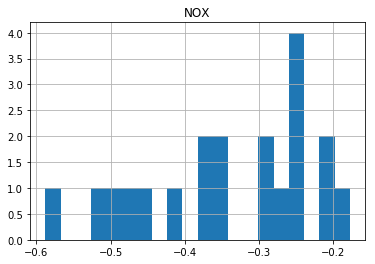

In [38]:
im=W.hist('NOX',bins=20)

## Text explainer using the newsgroups

In [39]:
# run the text explainer example notebook, up to single explanation
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

/Users/dyanni3/anaconda/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Document id: 83
Probability(christian) = 0.444
True class: atheism


In [40]:
sp_obj=SubmodularPick(explainer, newsgroups_test.data, c.predict_proba, sample_size=2, num_features=6,num_exps_desired=2,top_labels=3)

/Users/dyanni3/anaconda/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


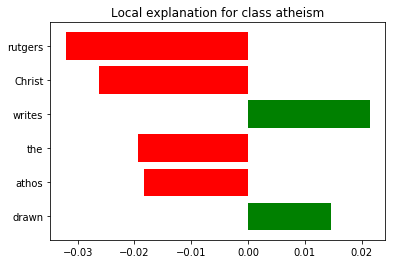

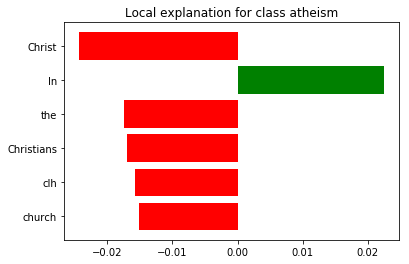

In [41]:
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations];

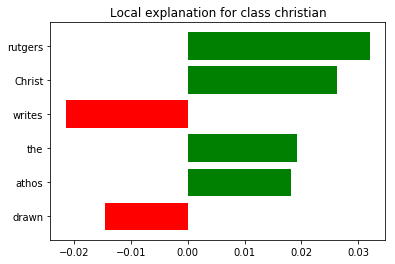

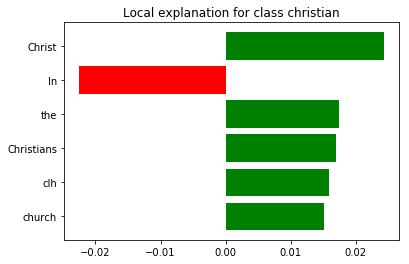

In [42]:
[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations];

In [43]:
from sklearn.datasets import load_iris
iris=load_iris()
from sklearn.cross_validation import train_test_split as tts
Xtrain,Xtest,ytrain,ytest=tts(iris.data,iris.target,test_size=.2)
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(Xtrain,ytrain)
rf.score(Xtest,ytest)

0.8333333333333334

In [44]:
explainer = lime.lime_tabular.LimeTabularExplainer(Xtrain, 
                                                   feature_names=iris.feature_names,
                                                   class_names=iris.target_names, 
                                                   verbose=False, 
                                                   mode='classification',
                                                   discretize_continuous=False)

In [45]:
exp=explainer.explain_instance(Xtrain[i],rf.predict_proba,top_labels=3)
exp.available_labels()

[1, 2, 0]

In [46]:
sp_obj=SubmodularPick(data=Xtrain,explainer=explainer,num_exps_desired=5,predict_fn=rf.predict_proba, sample_size=20, top_labels=3, num_features=4)

In [47]:
import pandas as pd
df=pd.DataFrame({})
for this_label in range(3):
    dfl=[]
    for i,exp in enumerate(sp_obj.sp_explanations):
        l=exp.as_list(label=this_label)
        l.append(("exp number",i))
        dfl.append(dict(l))
    dftest=pd.DataFrame(dfl)
    df=df.append(pd.DataFrame(dfl,index=[iris.target_names[this_label] for i in range(len(sp_obj.sp_explanations))]))
df

,exp number,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
setosa,0,-0.082228,-0.236923,-0.032294,0.012060
setosa,1,-0.090088,-0.260716,-0.025831,0.012220
setosa,2,-0.061403,-0.203016,-0.032648,0.008165
setosa,3,-0.115855,-0.326017,-0.043795,0.021527
setosa,4,-0.108132,-0.319248,-0.043905,0.014563
versicolor,0,-0.180320,0.074353,0.047606,-0.000603
versicolor,1,-0.130953,0.108325,0.049563,-0.012690
versicolor,2,-0.224952,0.035047,0.027544,-0.009744
versicolor,3,-0.009624,0.215826,0.085704,-0.021219
versicolor,4,-0.032447,0.207419,0.082044,-0.020580
